In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
dep_var_name = 'Murder and nonnegligent manslaughter'
other_crime_colnames = ['Aggravated assault','Burglary','Counties/principal cities','Larceny','Motor vehicle theft','Murder and nonnegligent manslaughter','Property crime','Rape','Robbery','Violent crime']
other_crime_colnames.remove(dep_var_name)

In [3]:
#read in
all_df = pd.read_csv('data/derived/crime_ACS_merged.csv', index_col=0, low_memory=False)
print(all_df.shape)
all_df.columns  # [:20]
all_df.head(3)

(3283, 563)


,Aggravated assault,Burglary,Counties/principal cities,Larceny,Motor vehicle theft,Murder and nonnegligent manslaughter,Population,Property crime,Rape,Robbery,...,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1940 to 1949,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later
2,227.8,649.9,"Rate per 100,000 inhabitants",2077.9,175.4,6.5,NaN,2903.1,46.5,80.6,...,9.5,8.4,18.6,11.1,15.0,15.5,8.6,9.3,2.6,1.5
6,121.0,563.3,"Rate per 100,000 inhabitants",1857.3,144.0,6.0,NaN,2564.5,48.9,77.3,...,19.0,7.2,14.9,11.6,13.9,9.1,12.9,9.4,1.5,0.6
10,534.9,949.8,"Rate per 100,000 inhabitants",2676.9,144.2,11.8,NaN,3770.8,28.2,159.9,...,6.2,3.2,9.7,14.0,15.2,15.4,17.0,16.9,1.9,0.3


In [21]:
#Non-numeric columns, missing dependent variable, other crime data

#TODO: un-hackify this
#all columns to numeric
for col in all_df.columns.values:
    all_df.loc[:, col] = pd.to_numeric(all_df[col], errors='coerce')

#drop columns with many NaN (likely those that were text data)
bad_cols = all_df.isnull().sum() > 100
all_df = all_df.loc[:, ~bad_cols]


#deal with missing dependent variable (by dropping those rows)
missing_dv = all_df[dep_var_name].isnull()
all_df = all_df.loc[~missing_dv, :]

#Drop crime data that isn't the dependent variable (using that data is prettymuch cheating)
all_df=all_df[all_df.columns.difference(other_crime_colnames)]

print(all_df.shape)
all_df.head()

(3275, 336)


,Estimate; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Total households - Mean household income (dollars),Estimate; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars),Estimate; SEX AND AGE - Median age (years),Id2,Murder and nonnegligent manslaughter,Percent; ANCESTRY - Total population,Percent; ANCESTRY - Total population - American,Percent; ANCESTRY - Total population - Arab,Percent; ANCESTRY - Total population - Czech,Percent; ANCESTRY - Total population - Danish,...,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later,msa_pop,year
2,62145,48016,34.4,10180,6.5,170860.0,6.0,0.0,0.1,0.1,...,18.6,11.1,15.0,15.5,8.6,9.3,2.6,1.5,169885,2016
6,70083,51598,40.2,10420,6.0,702221.0,10.1,1.5,1.0,0.1,...,14.9,11.6,13.9,9.1,12.9,9.4,1.5,0.6,703561,2016
10,57901,40667,36.4,10500,11.8,152506.0,15.1,0.0,0.0,0.0,...,9.7,14.0,15.2,15.4,17.0,16.9,1.9,0.3,152566,2016
13,69891,51310,39.4,10540,0.0,122849.0,6.2,0.8,0.4,0.6,...,8.7,9.7,20.9,7.9,16.8,12.9,2.5,1.1,122030,2016
18,85684,65855,39.8,10580,2.0,881839.0,4.3,0.8,0.4,0.4,...,9.8,8.9,11.3,12.1,9.6,8.9,2.8,0.9,878166,2016


In [24]:
#train/test split

x_data=all_df[all_df.columns.difference(['Murder and nonnegligent manslaughter'])]
y_data=all_df['Murder and nonnegligent manslaughter']

train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
train_x.shape

(2292, 335)

In [6]:
#Deal with missing column entries
def impute_missing(train_data, test_data):
    #TODO: better handling of missing items in the remainging columns
    train_means = train_data.mean().to_dict()
    
    imputed_train = train_data.fillna(train_means, axis=0)
    imputed_test = test_data.fillna(train_means, axis=0)
    
    #note: does not change the input data, just returns the updated result
    return imputed_train,imputed_test


#PCA to reduce dimension
def do_PCA_transform(train_data, test_data, percent_explained):

    imputed_train, imputed_test = impute_missing(train_data, test_data)
    
    scaler = StandardScaler().fit(imputed_train)
    imputed_train = scaler.transform(imputed_train)
    imputed_test = scaler.transform(imputed_test)

    
    pca = PCA(n_components=percent_explained).fit(imputed_train)
    
    pca_train_data = pca.transform(imputed_train)
    pca_test_data = pca.transform(imputed_test)

    return pca_train_data,pca_test_data

do_PCA_transform(train_x, test_x,.8)[0].shape

(2292, 33)

In [7]:
#CV to pick a ridge regression model
cv_folds=5
pca_values = [.3,.4,.5,.6,.7,.8,.9,.99]
alpha_values = np.logspace(-5,5)

cv_scores = np.zeros((cv_folds, len(pca_values), len(alpha_values)))


kf = KFold(n_splits=cv_folds, random_state=3, shuffle=False)
cv_index = -1
for train_index, test_index in kf.split(train_x):
    cv_index += 1
    print("Working on CV fold",cv_index)
    cv_train_x, cv_test_x = train_x.iloc[train_index,:], train_x.iloc[test_index,:]
    cv_train_y, cv_test_y = train_y.iloc[train_index], train_y.iloc[test_index]

    for pca_index, cur_percent_explained in enumerate(pca_values):
        #fit the PCA
        pca_cv_train_x, pca_cv_test_x = do_PCA_transform(cv_train_x, cv_test_x, 
                                                         cur_percent_explained)

        for alpha_index, cur_alpha in enumerate(alpha_values):
            #fit the model
            fitted_model = Lasso(alpha=cur_alpha).fit(pca_cv_train_x,cv_train_y)

            #store the result
            cv_scores[cv_index, pca_index, alpha_index] = fitted_model.score(pca_cv_test_x, cv_test_y)
print("Done")

Working on CV fold 0
Working on CV fold 1
Working on CV fold 2
Working on CV fold 3
Working on CV fold 4
Done


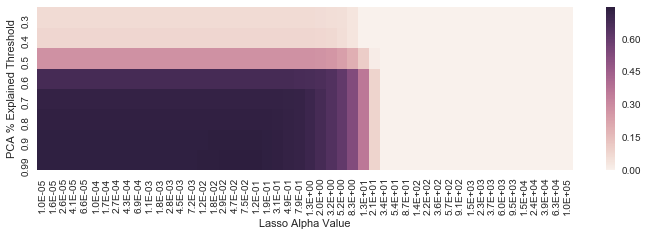

In [8]:
#means and SDs
means = pd.DataFrame(cv_scores.mean(axis=(0)), index=pca_values, columns=alpha_values)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
sns.heatmap(means, xticklabels=[format(v, '1.1E') for v in alpha_values], ax=ax, vmin=0)
plt.xlabel('Lasso Alpha Value')
plt.ylabel('PCA % Explained Threshold')
plt.show()

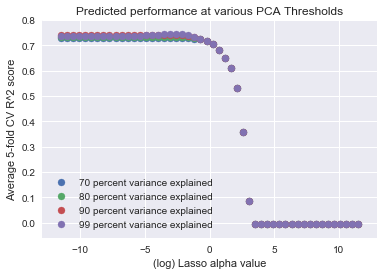

In [9]:
#plot of falloff
for x in range(4,8):
    plt.scatter(np.log(means.iloc[x,:].index), means.iloc[x,:])
plt.legend(["{:0.0f}".format(100*x)+" percent variance explained" for x in pca_values[4:8]])
plt.title("Predicted performance at various PCA Thresholds")
plt.ylabel('Average 5-fold CV R^2 score')
plt.xlabel('(log) Lasso alpha value')
plt.show()

TODO: REVISE. In the above we see that that PCA percent of .8 and basically any alpha value works well, provided the alpha isn't too big. There is a severe cascade where incresing alpha reduces to guessing the mean of the trainng data, regardless of the PCA setting, earning a lower-than-zero R^2 score in the cv test set.

In [20]:
#get optimal params, fit to whole data
best_pca_percent_index, best_alpha_index = np.unravel_index(np.argmax(means.values), means.shape)

#fit the model to the whole data
pca_train_x, pca_test_x = do_PCA_transform(train_x, test_x, pca_values[best_pca_percent_index])
fitted_model = Lasso(alpha=alpha_values[best_alpha_index]).fit(pca_train_x,train_y)

fitted_model.score(pca_train_x,train_y)#for proof it works

0.77992248528062991

In [11]:
#[Do not open until Thursday: see how well we do on test]

#fitted_model.score(pca_test_x,test_y) #Not yet run. Despite the temptation to test this line.